In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

np.random.seed(27112018)

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


Text(0.5,1,'KDE')

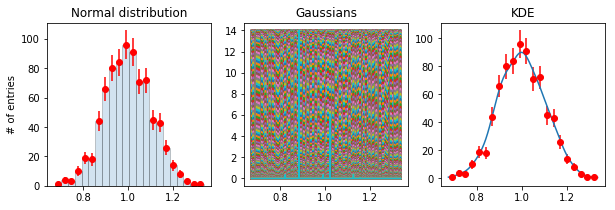

In [2]:
mean = 1
sigma = 0.1
N = 800
# Generate Normal distributed values
x = np.random.normal(mean, sigma, N)
# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
# Get information about the histogram
n, bins, patches = ax1.hist(x, bins="auto", alpha=0.2, ec="black")
# Calculate and display errors
errors = n**0.5
bincenters = []
for i in range (len(bins)-1):
    bincenters.append(0.5*(bins[i+1]+bins[i]))
ax1.errorbar(bincenters, n, yerr=errors, fmt="ro")
ax1.set_ylabel("# of entries")
ax1.set_title("Normal distribution")

# Calculate gaussians for KDE
stderr = 1.06*x.std()*x.size**(-1/5)
points = np.linspace(x.min(), x.max(), N)
gaussians = np.zeros((N, N))
for i in range(N):
    gaussians[i] = sp.stats.norm.pdf(x=points, loc=x[i], scale=stderr)
ax2.plot(points,gaussians)
ax2.set_title("Gaussians")

# Compute KDE
Gauss = gaussians.sum(axis=0)
Norm = np.sum(np.diff(bins)*n) / sp.integrate.trapz(y=Gauss, x=points)
ax3.errorbar(bincenters, n, yerr=errors, fmt="ro")
ax3.plot(points, Gauss*Norm)
ax1.set_ylabel("# of entries")
ax3.set_title("KDE")

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

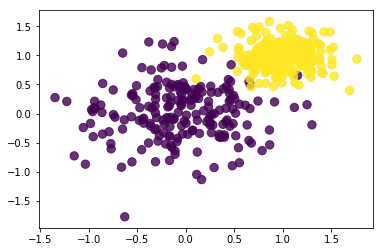

In [56]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


/mnt/d/Download/WindowsSubSystemForLinux/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  import sys


Text(0,0.5,'y')

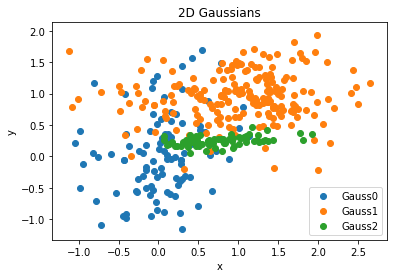

In [3]:
def Gauss2D(mean, std, N): #mean = [[x1,y1], [x2,y2] ... , [xN, yN]] = 2D means array
                           #std  = [[[xx1, xy1], [yx1, yy1]], ... , [[xxN, xyN], [yxN, yyN]]] = 2D cov matrix array
                           #N    = [N1, N2, ... , NN] = number of generated samples 
    gauss = []
    num = len(mean)
    for i in range(num):
        gauss.append(np.random.multivariate_normal(mean[i], std[i], N[i]))
    
    return gauss
    

mean1 = np.array([0, 0])
mean2 = np.array([1, 1])
mean3 = np.array([0.75, 0.25])
mean  = [mean1, mean2, mean3]
std1  = np.array([[0.2, 0.07], [0.05, 0.3]])
std2  = np.array([[0.6, 0.03], [0.09, 0.15]])
std3  = np.array([[0.2, 0.01], [0.1, 0.]])
std   = [std1, std2, std3]
N1 = 100
N2 = 200
N3 = 75
N  = [N1, N2, N3]

gauss = Gauss2D(mean, std, N)

fig, ax = plt.subplots()

for i in range(len(gauss)):
    ax.scatter(x=gauss[i][:,0], y=gauss[i][:,1], label="Gauss"+str(i))
    
ax.legend()
ax.set_title("2D Gaussians")
ax.set_xlabel("x")
ax.set_ylabel("y")

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should do the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [14]:
np.load("./residuals_261.npy").item()

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
         0.16666667,  0.08333333]),
 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])}


***Scipy linear regression***
slope = 0.0032597701220305835
intercept = -0.15432816763069473
r_value = 0.043403510522559086
pvalue = 8.717037183576464e-06
std_err = 0.0007327014008445789
***



<ErrorbarContainer object of 3 artists>

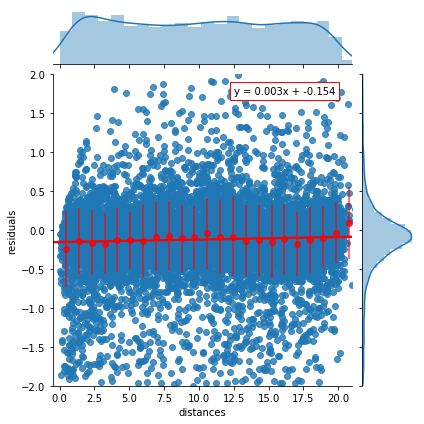

In [232]:
# load the dataset as Pandas DataFrame
data = np.load("./residuals_261.npy").item()
dataset = pd.DataFrame(data)
#print(dataset.describe())
# Clean the dataset
dataset = dataset[abs(dataset["residuals"]) < 2]
#print(dataset.describe())
# linear regression
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x=dataset["distances"], y=dataset["residuals"])
print("\n***Scipy linear regression***")
print("slope =", slope)
print("intercept =", intercept)
print("r_value =", r_value)
print("pvalue =", p_value)
print("std_err =", std_err)
print("***\n")
ax = sns.jointplot(x="distances", y="residuals", data=dataset, kind="reg", xlim=[-0.5, 21], ylim=[-2,2], joint_kws={'line_kws':{'color':'red'}})
plt.text(x=12.5, y=1.75, s="y = {0:.3f}x + {1:.3f}".format(slope, intercept), bbox=dict(ec='red',fc="white"))

n, bins = np.histogram(dataset["distances"], bins="auto")
x = []
for i in range (len(n)):
    x.append(0.5*(bins[i+1]+bins[i]))
# add a column indicating the bin number
dataset["bin"] = ""

for i in range(len(x)):
    mask = (xbins[i] < dataset["distances"]) & (dataset["distances"] < xbins[i+1])
    dataset.loc[mask, "bin"] = i

y = dataset.groupby("bin").mean()["residuals"].values
erry = dataset.groupby("bin").std()["residuals"].values
plt.errorbar(x, y, yerr=erry, fmt="ro", alpha=0.75)